In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import sys
sys.path.append('..')

1.12.0


In [3]:
from configs.seq_fd_gru import hparams
hparams = hparams()
print(hparams)

[('batch_size', 800), ('datagen', 'prodn'), ('in_seq_len', 168), ('input_channels', 1), ('input_dim', 5), ('lambd', 1e-06), ('learning_rate', 0.001), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.99), ('neurons_unit', 32), ('norm_epsilon', 1e-12), ('num_layers', 1), ('out_seq_len', 24), ('output_channels', 1), ('output_dim', 1), ('test_split', 0.1), ('train_split', 0.8), ('val_split', 0.1)]


In [166]:
hparams=tf.contrib.training.HParams(
        batch_size=800,
        in_seq_len=32 * 24,
        input_dim=5,
        input_channels=1,
        out_seq_len=24,
        output_dim=1,
        output_channels=1,
        num_layers=1,
        neurons_unit=32,
        learning_rate = 10 ** -2.5,
        lr_decay = 0.99,
        lambd = 1e-6,
        train_split = 0.8,
        val_split = 0.1,
        test_split = 0.1,
        norm_epsilon = 1e-12,
        datagen = 'prodn',
        logs_path = '/tmp/tensorflow_logs')

In [164]:
from data_loader.biogas import *
get_fields = 'AT305'
dataset, dataset_val, dataset_test = load_data(hparams, mode=get_fields, normalise='local_max')
inp, target, mask, x_max = next(iter(dataset))

In [6]:
tf.keras.layers.Conv1D(1, 2, padding='valid', activation='linear', use_bias=False,
                                         kernel_initializer = tf.constant_initializer([-1,1]))

In [116]:
class pAttention(tf.keras.Model):
    def __init__(self):
        super(pAttention, self).__init__()
        self.W1 = tf.Variable(2., name='W_separation')
        self.W2 = tf.Variable(1., name='W_scale')
        self.w  = None

    def cov(self, x):

        n_dim  = tf.cast(tf.shape(x)[1], tf.float32) - 1
        mu_x   = x - tf.reduce_mean(x, axis=1, keep_dims=True)
        cov_xx = tf.matmul(mu_x, mu_x, transpose_a=True) / n_dim
        
        return cov_xx
    
    def var(self, x):
        xx = tf.expand_dims(x, axis=-1)
        xx = xx - tf.transpose(xx, [0,1,3,2])
        mu_xx, var_xx = tf.nn.moments(xx, [1])
        
        return var_xx
        
    def call(self, x, hidden, mode='var'):
        if mode == 'var':
            context = self.var(x)
        else:
            context = self.cov(x)
            
        context     = tf.reduce_sum(context, axis=1)
        context_max = tf.reduce_max(context, axis=1, keep_dims=True)
        
        if mode == 'var':
            context = (context_max - context) / context_max
        else:
            context = context / context_max

        score   = tf.exp(self.W1) * context
        weights = tf.nn.softmax(score, axis=1)
        weights = tf.expand_dims(weights, axis=1)
        self.w  = weights
        
        outputs = self.W2 * tf.reduce_mean(weights * tf.squeeze(hidden), axis=-1, keepdims=True) 
        
        return outputs

In [99]:
i = np.array(inp[608,:,:,0])
mu_i  = i - np.mean(i, keepdims = True)
cov_i = mu_i.T.dot(mu_i)
cov_i, cov_i.sum(axis=1)

(array([[ 0.01280322,  0.01010991,  0.01752666, -0.0061983 ,  0.00085185],
        [ 0.01010991,  0.01629682,  0.01105879, -0.01112399, -0.00810339],
        [ 0.01752666,  0.01105879,  0.07450998,  0.00022164,  0.00699959],
        [-0.0061983 , -0.01112399,  0.00022164,  0.01235891,  0.0113797 ],
        [ 0.00085185, -0.00810339,  0.00699959,  0.0113797 ,  0.0210997 ]],
       dtype=float32),
 array([0.03509334, 0.01823813, 0.11031665, 0.00663796, 0.03222744],
       dtype=float32))

In [100]:
i = inp[168,:,:,0]
i_d = i[:,np.newaxis,:] - i[:,:,np.newaxis]
i_v = np.var(i_d, axis=0)
i_v, i_v.sum(axis=1)

(array([[0.0000000e+00, 2.5867482e-04, 2.1254600e-03, 3.5519432e-04,
         2.6991201e-04],
        [2.5867482e-04, 0.0000000e+00, 2.5464511e-03, 6.5904540e-05,
         3.5955841e-04],
        [2.1254600e-03, 2.5464511e-03, 0.0000000e+00, 2.8410759e-03,
         2.7489837e-03],
        [3.5519432e-04, 6.5904540e-05, 2.8410759e-03, 0.0000000e+00,
         4.4162126e-04],
        [2.6991201e-04, 3.5955841e-04, 2.7489837e-03, 4.4162126e-04,
         0.0000000e+00]], dtype=float32),
 array([0.00300924, 0.00323059, 0.01026197, 0.0037038 , 0.00382008],
       dtype=float32))

In [76]:
i_d = inp - tf.transpose(inp, [0,1,3,2])
i_m, i_v = tf.nn.moments(i_d, [1])
i_v.shape

TensorShape([Dimension(800), Dimension(5), Dimension(5)])

In [77]:
i_v[0]

<tf.Tensor: id=340428, shape=(5, 5), dtype=float32, numpy=
array([[0.0000000e+00, 1.7083426e-03, 3.6946798e-04, 2.5687201e-04,
        3.6531920e-04],
       [1.7083426e-03, 0.0000000e+00, 1.1802994e-03, 1.3205219e-03,
        2.4294674e-03],
       [3.6946798e-04, 1.1802994e-03, 0.0000000e+00, 7.6796779e-05,
        5.0041050e-04],
       [2.5687201e-04, 1.3205219e-03, 7.6796779e-05, 0.0000000e+00,
        2.8558835e-04],
       [3.6531920e-04, 2.4294674e-03, 5.0041050e-04, 2.8558835e-04,
        0.0000000e+00]], dtype=float32)>

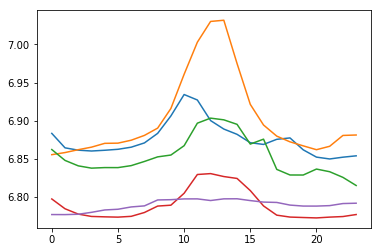

In [36]:
plt.plot(i)

In [167]:
class MicroConvRNN(tf.keras.Model):
    def __init__(self, input_dim, output_dim, in_seq_len, out_seq_len, neurons_unit, batch_size, name=None):
        super(MicroConvRNN, self).__init__()

        self.input_dim    = input_dim
        self.output_dim   = output_dim
        self.in_seq_len   = in_seq_len
        self.out_seq_len  = out_seq_len
        self.neurons_unit = neurons_unit
        self.batch_size   = batch_size
        
        self.conv1_2x1  = tf.keras.layers.Conv1D(1, 2, padding='valid', activation='linear', use_bias=False,
                                                 kernel_initializer = tf.constant_initializer([-1,1]),
                                                 name='conv1_first_diff_2')
        self.attn = pAttention()
        
    def reshape_deep(self, x):
        x = tf.reshape(x, [self.batch_size, self.input_dim, self.out_seq_len, -1])
        return tf.transpose(x, [0,2,1,3])
        
    def reshape_wide(self, x):
        x = tf.transpose(x, [0,2,1,3])
        return tf.reshape(x, [self.batch_size, self.input_dim * self.out_seq_len, -1])
    
    def encode(self, x):
        pos = self.out_seq_len * self.input_dim
        
        conv1 = self.conv1_2x1(x)

        return self.reshape_deep(conv1[:,-pos:])
        
    def call(self, inp, mask):
        
        enc_out = self.encode(inp)
        
        pos = self.out_seq_len * self.input_dim
        context = self.reshape_deep(inp[:,-pos:])
        context = self.attn(tf.squeeze(context), enc_out)
        context = tf.cumsum(context, axis=1)
        
        x = inp[:,-1:]

        return (x + context) * mask

In [ ]:
n = 24
pos = hparams.out_seq_len * hparams.input_dim
print(model.conv1_2x1.variables)

plt.plot(np.array(fcast[n]))
plt.plot(np.array(model.reshape_deep(inp[:,-pos:]))[n,:,:,0], '--')
plt.show()

plt.figure(figsize=(12,4))
ax = plt.subplot(1,2,1)
ax.plot(np.array(conv1[n]).sum(axis=(1)), label='2x1 conv sum')
ax.plot(np.array(conv1[n]).mean(axis=(1)), label='2x1 conv mean')
ax.plot(np.cumsum(conv1[n], axis=0).mean(axis=(1)), label='2x1 conv cumsum')
plt.legend()
ax = plt.subplot(1,2,2)
ax.plot(np.array(cox[n]), '--', label='context')
ax.plot(np.array(cox[n]).mean(axis=1))
plt.legend()
plt.show()

plt.plot(np.array(inp[n,-120:]))
plt.show()

## Train Model
loss_function: Build out MSE loss function with parameter regularisation

train_model: Runs the minibatch training loop

Loss 0.0165 Accuracy 0.0152 Time 56.0978


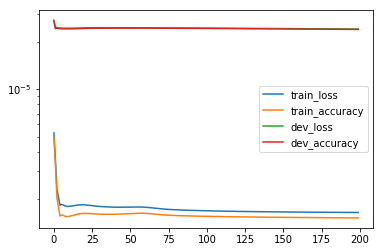

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_first_diff_2 (Conv1D)  multiple                  2         
_________________________________________________________________
p_attention_13 (pAttention)  multiple                  2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [168]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model = MicroConvRNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
                hparams.neurons_unit, hparams.batch_size)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams,
                                                      epochs=200, verbose=False, dev_dataset=dataset_val)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 10000, accuracy * 10000, run_time))

plt.figure()
for name, stat in stats.items():
    if name != 'time':
        plt.plot(stat, label=name)
plt.legend()
plt.yscale('log')
plt.show()

#trainer.save_model(model, optimizer, dataset_val, hparams, 'fd_mini' + get_fields.replace(' ', '_'), stats=stats)
model.summary()

In [169]:
model.variables, optimizer._lr

([<tf.Variable 'micro_conv_rnn_13/conv1_first_diff_2/kernel:0' shape=(2, 1, 1) dtype=float32, numpy=
  array([[[-0.9999893 ]],
  
         [[ 0.99999356]]], dtype=float32)>,
  <tf.Variable 'W_separation:0' shape=() dtype=float32, numpy=0.2562777>,
  <tf.Variable 'W_scale:0' shape=() dtype=float32, numpy=0.97616607>],
 0.0004236809327199552)

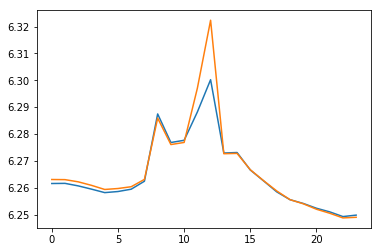

In [172]:
plt.plot(np.sum(model.attn.w[TARGET_INDEX] * inp[TARGET_INDEX,:,:,0], axis=1))
plt.plot(np.mean(inp[TARGET_INDEX,:,:,0], axis=1))

In [174]:
inp, target, mask, x_max = next(iter(dataset))
inp.shape

TensorShape([Dimension(800), Dimension(768), Dimension(1)])

In [175]:
# show all sequences
# Select target sequence to show
TARGET_INDEX = 168

# Create forecast and rescale data
inp, target, mask, x_max = next(iter(dataset))
x_max = tf.expand_dims(x_max,-1)
forecast = model(inp, mask)
forecast *= x_max
target   *= x_max
inp      *= x_max
inp = tf.reshape(inp[:,-120:], [hparams.batch_size, hparams.input_dim, hparams.out_seq_len, -1])
inp = tf.transpose(inp, [0,2,1,3])

# Plot target sequence
print('Attention Weights: ', ['{:.1f}'.format(i * 100) for i in model.attn.w[TARGET_INDEX,0]])
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX,:,0]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX,:,0]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX,:,0], 'bo', label='5 period average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i,0], '--', label='%i periods prior' % (5-i))
plt.legend()
plt.show()

plt.figure(figsize=(16,16))
for i in range(0,800,8):
    ax = plt.subplot(10,10,i/8+1)
    ax.plot(np.squeeze(forecast[i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

InvalidArgumentError: Input to reshape is a tensor with 614400 values, but the requested shape requires a multiple of 96000 [Op:Reshape]

## Test Hyperparameters

In [22]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

inp, target, mask, x_max = next(iter(dataset))

#for lr in np.random.uniform(-8, -1, 10):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model_ = MicroConvRNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
                       hparams.neurons_unit, hparams.batch_size)
    optimizer_ = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        trainer.train_model(model_, optimizer_, dataset, hparams, epochs = 50, verbose=False)
    print('Learning Rate {:.4f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(lr, loss*10000, accuracy * 10000, run_time))
    
    models.append(model_)
    stats.append(stat)

Learning Rate -4.0000 Loss 0.0309 Accuracy 0.0280 Time 11.2
Learning Rate -3.5000 Loss 0.0307 Accuracy 0.0280 Time 11.1
Learning Rate -3.0000 Loss 0.0301 Accuracy 0.0278 Time 11.1
Learning Rate -2.5000 Loss 0.0288 Accuracy 0.0273 Time 11.0
Learning Rate -2.0000 Loss 0.0278 Accuracy 0.0268 Time 11.1
Learning Rate -1.5000 Loss 0.0279 Accuracy 0.0269 Time 11.2
Learning Rate -1.0000 Loss 0.0282 Accuracy 0.0278 Time 11.2
Learning Rate -0.5000 Loss 0.0282 Accuracy 0.0280 Time 11.0


## Test Model Accuracy

In [16]:
model_accuracy = []

Total Accuracy: 0.0278


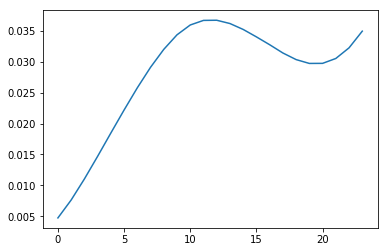

In [24]:
START_POINT = 0
total_accuracy = []
x_variance = x_var(hparams, mode=get_fields, normalise='local_max_min')

for i, (inp, target, mask, x_max) in enumerate(dataset_test):
    forecast = model(inp, mask)

    accuracy = tf.squeeze(forecast - target) * x_max
    accuracy = accuracy ** 2 / x_variance
    accuracy = np.mean(accuracy, axis=0)
    
    total_accuracy.append(accuracy)

model_accuracy.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))
    
print('Total Accuracy: %.4f' % np.mean(total_accuracy))
plt.plot(np.mean(total_accuracy, axis=0))
plt.show()

In [25]:
preds = np.array(forecast[:,:,0])*np.array(x_max)
acts  = np.array(target[:,:,0])*np.array(x_max)
errors = np.abs(preds - acts)

mses = np.mean(errors**2, axis = 0)
maes = np.mean(errors, axis = 0)
mapes = np.mean(errors/acts, axis = 0)
rses = np.mean(errors**2, axis = 0)/np.var(acts, axis = 0)

In [27]:
rses

0.0024868366